In [2]:
from rasterstats import zonal_stats, point_query
import os
import pickle
import matplotlib.pyplot as plt
import csv
import numpy as np

# Make stats
This script uses rasterstats to extract per country statistics on multiple nighttime satellite images. Borders need to be defined in a shapefile, such as [this one from Natural Earth](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/). It compiles the mean, std, sum, and median, as well as any information contained in the shapefile, for each country and each year available in the rasters folder. Then everything is saved in the stats.pickle file to be used later.

The raster files' names must contain the year followed by a dot, for example : "F162009.v4b.avg_lights_x_pct.tif" or "2009.tif" for 2009.

In [ ]:
## PARAMETERS ##
rasters_path = '../data/lightrasters_noaa'
vector_path = '../data/borders/ne_10m_admin_0_countries.shp'
################


stats = {}

# valid countries list : https://unstats.un.org/unsd/methodology/m49/

for entry in os.scandir(rasters_path):
    filename, *_, extension = entry.name.split(".")
    if extension != 'tif':
        continue

    global_stats = zonal_stats(vector_path, entry.path,
                               stats="mean sum std median",
                               all_touched=True,
                               geojson_out=True)

    for c in global_stats:
        print(c['properties'])
        name = c['properties']['NAME_SORT']

        if name is None:
            name = c['properties']['NAME']
        
        if name not in stats:
            stats[name] = {}
        
        stats[name][filename] = c['properties']
            
    print(filename + " done")

pickle.dump(stats, open("stats.pickle", "wb" ))

print("all done !")

# Plots
This script uses the pickle file generated above to create line plots for every country showing the progression over every year observed. Here, we're also plotting the population and gdp for comparaison ([from UNdata for example](http://data.un.org/)). Those additional data must be CSV files, with the name of the country in the first column, the year in the second column, and the value in the third column.

Here's an example of a result :
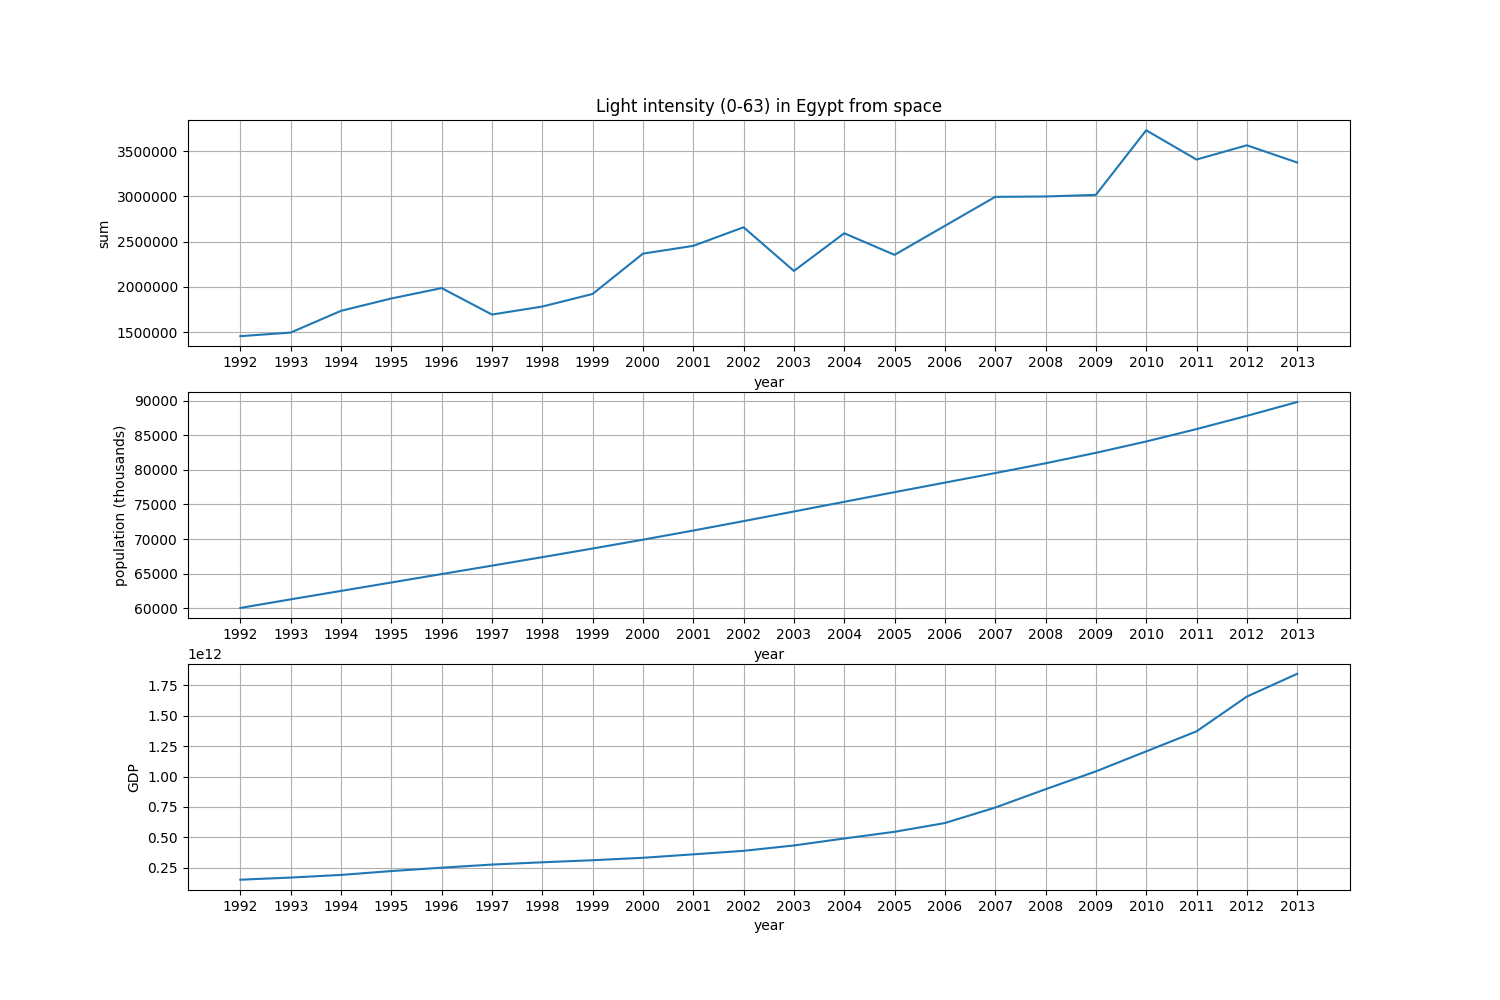

In [ ]:
## PARAMETERS ##
yaxiss = ['sum'] # available : 'mean', 'std', 'median', 'sum'
population_csv = '../data/population_per_country.csv'
gdp_csv = '../data/gdp_per_country.csv'
################

countries = pickle.load(open( "stats.pickle", "rb" ))
plt.rcParams["figure.figsize"] = (15,10)

population = []
with open(population_csv, 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        if row: 
            population.append(row)
            
gdp = []
with open(gdp_csv, 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        if row: 
            gdp.append(row)

# remove headers
gdp.pop(0)    
population.pop(0)

for yaxis in yaxiss:
    for country, years in countries.items():
        x = []
        y1 = []
        y2 = []
        y3 = []
        
        for year in sorted(years):
            x.append(year[-4:])
            y1.append(years[year][yaxis])
            
            found = False
            for row in population:
                if row[0] == country and row[1] == year[-4:]:
                    y2.append(float(row[2]))
                    found = True
                    break
                
            if not found:
                y2.append(0)
            
            found = False
            for row in gdp:
                if row[0] == country and row[1] == year[-4:]:
                    y3.append(float(row[2]))
                    found = True
                    break
                
            if not found:
                y3.append(0)

        fig = plt.figure()
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(x, y1)
        ax1.set(xlabel='year', ylabel=yaxis, title='Light intensity (0-63) in ' + str(country) + ' from space')
        ax1.grid()

        ax2 = plt.subplot(3, 1, 2)
        ax2.plot(x, y2)
        ax2.set(xlabel='year', ylabel='population (thousands)', title='')
        ax2.grid()
        
        ax3 = plt.subplot(3, 1, 3)
        ax3.plot(x, y3)
        ax3.set(xlabel='year', ylabel='GDP', title='')
        ax3.grid()

        fig.savefig("plots/" + yaxis + "_" + str(country) + ".png")
        
        plt.close(fig)
print('plots done !')


# Scatterplots
To better get an idea of the global correlation between light, gdp and population, this script compiles 3 scatterplots showing every country colored by economic development for one year. To get such results, the [Natural Earth shapefile](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/) must have been used to generate the stats above. Here are the results for 2013, using the data from [UNdata](http://data.un.org/) and rasters from [the NOAA](https://ngdc.noaa.gov/eog/dmsp/downloadV4composites.html) :

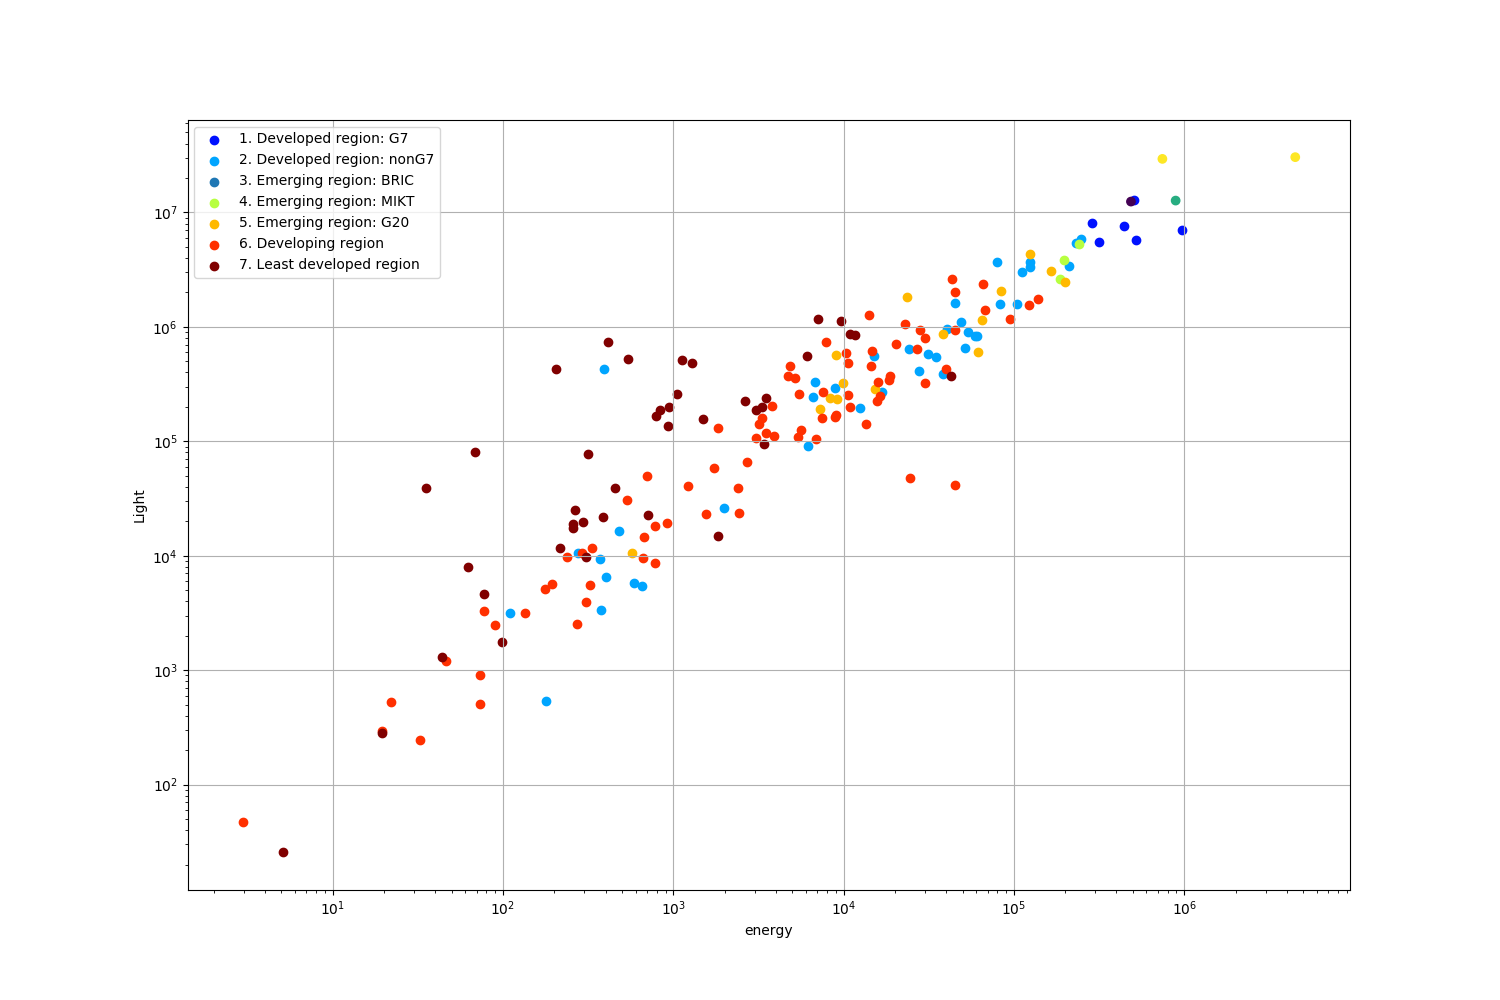

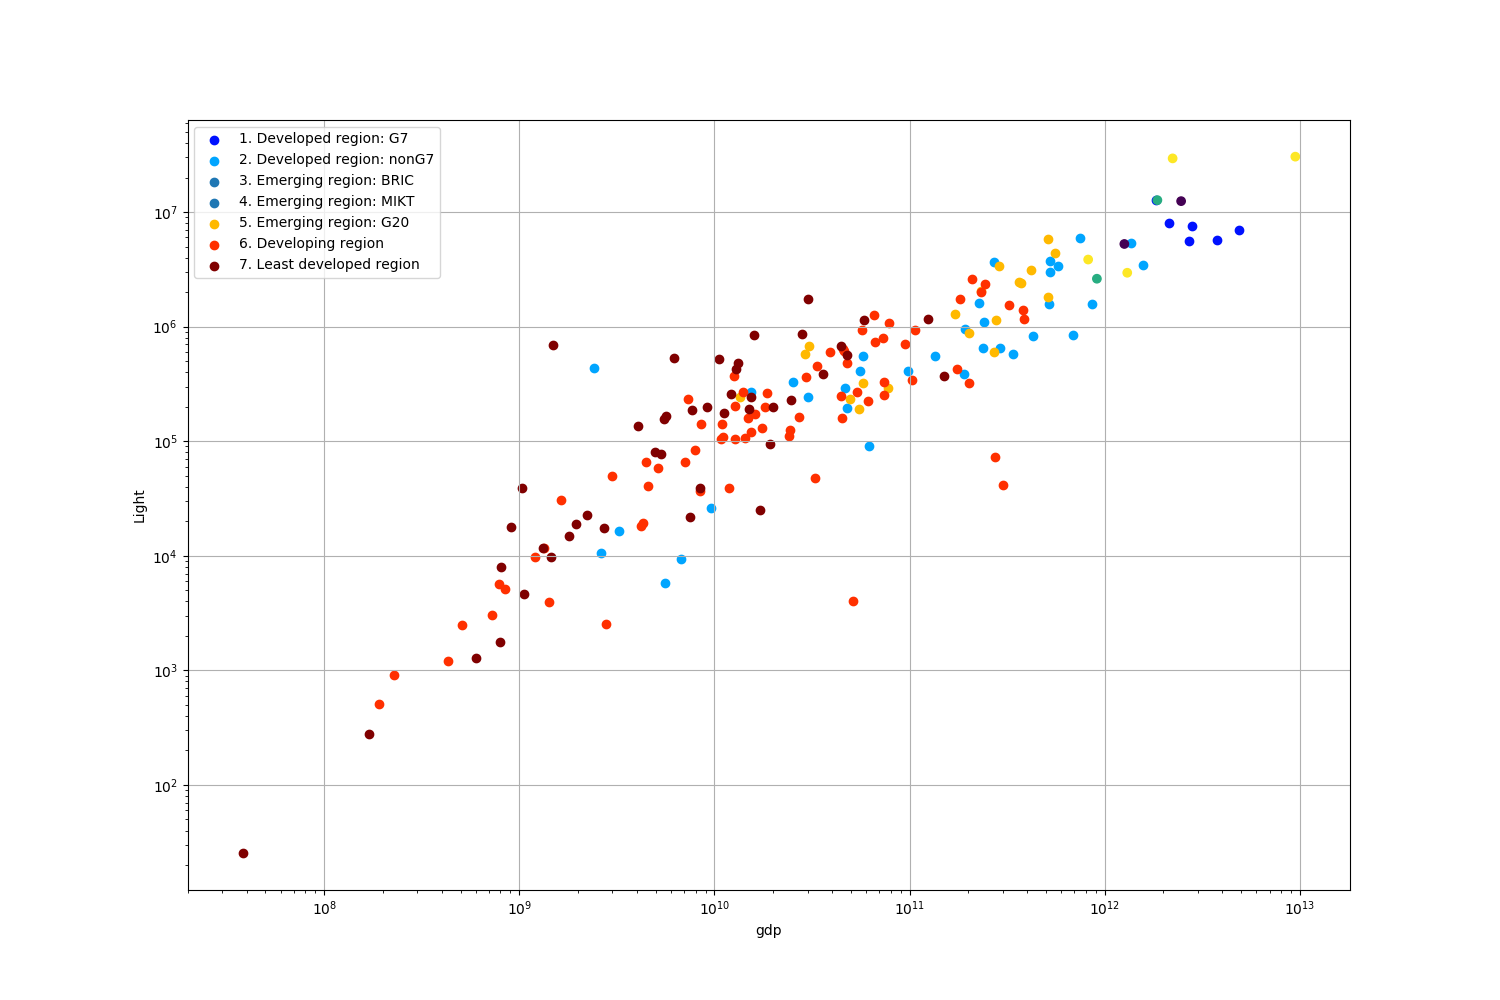

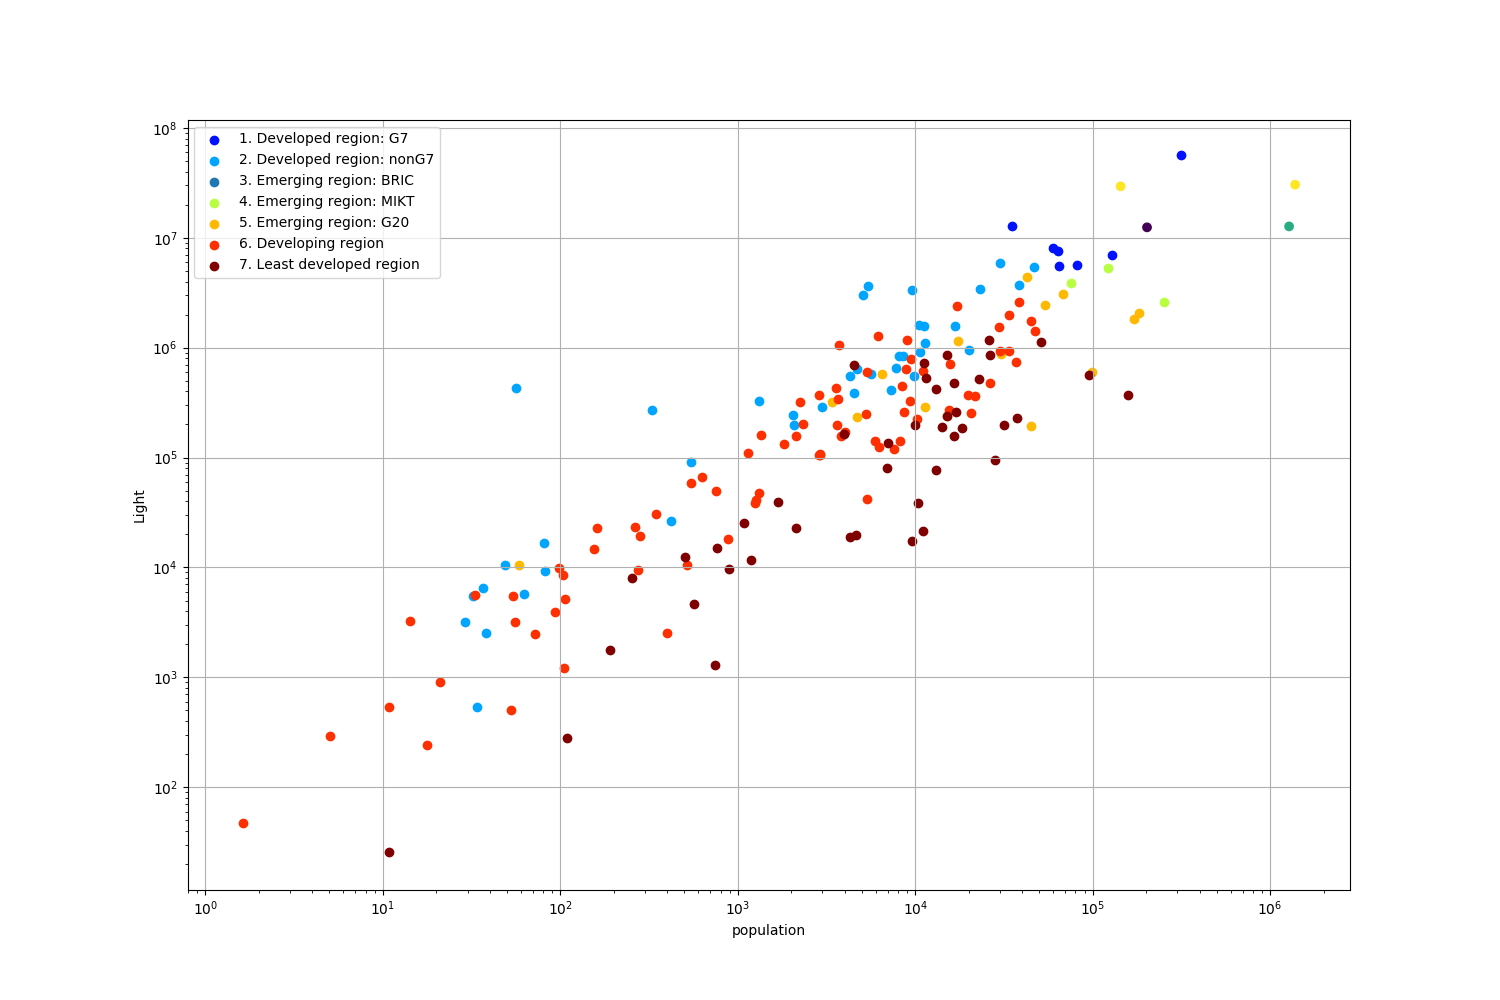

In [ ]:
## PARAMETERS ##
logscale = True  # use logarithmic scale
graph_year = '2013'
population_csv = '../data/population_per_country.csv'
gdp_csv = '../data/gdp_per_country.csv'
energy_csv = '../data/electricity_consumption_per_country.csv'
################

# load preprocessed data
countries = pickle.load(open( "stats.pickle", "rb" ))

plt.rcParams["figure.figsize"] = (15,10)

csv_data = {}

# load csv (format : [country, year, value])
csv_data['population'] = []
with open(population_csv, 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        if row: 
            csv_data['population'].append(row)
            
csv_data['gdp'] = []
with open(gdp_csv, 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        if row: 
            csv_data['gdp'].append(row)

csv_data['energy'] = []
with open(energy_csv, 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        if row: 
            csv_data['energy'].append(row)

# iterate over csv files
for k, g in csv_data.items() :
    g.pop(0)

    valuesX = []
    valuesY = []
    valuesZ = []

    # parcours les données de lumière par pays
    for country, years in countries.items():
        # parcours les données du pays par année
        for year in years:
            if not year[-4:] == graph_year:
                continue
            # cherche la ligne du csv correspondant au pays
            for row in g:
                if row[0] == country and row[1] == year[-4:]:
                    valuesX.append(float(row[3]))
                    valuesY.append(years[year]['sum']) # disponibles : 'mean', 'std', 'median', 'sum'
                    valuesZ.append(years[year]['ECONOMY'])
                    break
    
    fig = plt.figure()
    ax1 = plt.subplot(1, 1, 1)

    if logscale:
        plt.xscale('log')
        plt.yscale('log')
    
    # color Z axis
    uniqueZ = list(set(valuesZ))
    colors = [plt.cm.jet(float(i[0])/7) for i in sorted(uniqueZ)]
    
    for i, u in enumerate(sorted(uniqueZ)):
        xi = [valuesX[j] for j  in range(len(valuesX)) if valuesZ[j] == u]
        yi = [valuesY[j] for j  in range(len(valuesY)) if valuesZ[j] == u]
        ax1.scatter(xi, yi, c=colors[i], label=str(u))
    
    ax1.set(xlabel=k, ylabel='Light')
    ax1.legend()
    ax1.grid()

    fig.savefig("scatters/" + str(k) + "-light.png")
    plt.show()
    plt.close(fig)
    print(str(k)+" pearson coefficient : \n"+str(np.corrcoef(valuesX, valuesY)))

print('plots done !')
